In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [3]:
# for stock data
stock_data = pd.read_csv("C:/Users/HP/OneDrive/Desktop/Dissertation/Comparison-of-effect-of-Inflation-in-Stock-market-Indices/China/CMB Co.csv", index_col=0, parse_dates=[0], dayfirst=True,
                         header=0, names=['Date', 'open', 'high', 'low', 'close', 'volume'])

# for index data
# pd.read_csv("C:/Users/HP/OneDrive/Desktop/Dissertation/Comparison-of-effect-of-Inflation-in-Stock-market-Indices/S&P500.csv", index_col=0, parse_dates=[0], dayfirst=True,
#                          header=0, names=['Date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'])

stock_data.index = stock_data.index.strftime("%Y-%m")
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.sort_index()
print("Stock data\n")
print(stock_data.head())


Stock data

             open   high    low  close   volume
Date                                           
2007-02-01  16.89  18.36  14.99  16.09  1423039
2007-03-01  16.08  18.34  14.95  17.51  1779439
2007-04-01  17.42  20.78  17.06  19.47  2160406
2007-05-01  19.47  22.60  19.47  21.72  2101852
2007-06-01  21.85  25.95  19.78  24.58  1884266


In [4]:
inflation_data = pd.read_csv("C:/Users/HP/OneDrive/Desktop/Dissertation/Comparison-of-effect-of-Inflation-in-Stock-market-Indices/inflation rate 2000-2023.csv")

inflation_data = inflation_data.set_index('Date')
inflation_data.index = pd.to_datetime(inflation_data.index)
print("Inflation data\n")
print(inflation_data.head())

Inflation data

            us_inflation_rate  us_share_price  china_inflation_rate  \
Date                                                                  
2000-01-01           2.738892        39.55779                  -0.2   
2000-02-01           3.221884        43.48396                   0.7   
2000-03-01           3.757576        46.61248                  -0.2   
2000-04-01           3.068592        49.17913                  -0.3   
2000-05-01           3.188929        49.00218                   0.1   

            china_share_price  india_inflation_rate  india_share_price  
Date                                                                    
2000-01-01           19.75834              2.619048           62.86602  
2000-02-01           20.65533              3.614458           59.92387  
2000-03-01           19.18312              4.830918           61.62468  
2000-04-01           17.93419              5.542169           64.01819  
2000-05-01           15.61101              5.011

In [5]:
data = pd.concat([stock_data,
                  inflation_data.loc[:, ['china_inflation_rate', 'china_share_price']]],
                  axis='columns')

data.index = pd.to_datetime(data.index)

data = data.dropna()


In [6]:
def plot_price(column):
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=column, x=column.index, y=column, color="midnightblue")
    plt.title(f"{column.name} price distribution from 2000-present")
    plt.ylabel(f"{column.name} price")
    for yr in range(column.index[0].year, column.index[-1].year):
        plt.axvline(pd.to_datetime(str(yr)+'-01-01'), color='black', ls="--", alpha=0.3)
    plt.show()

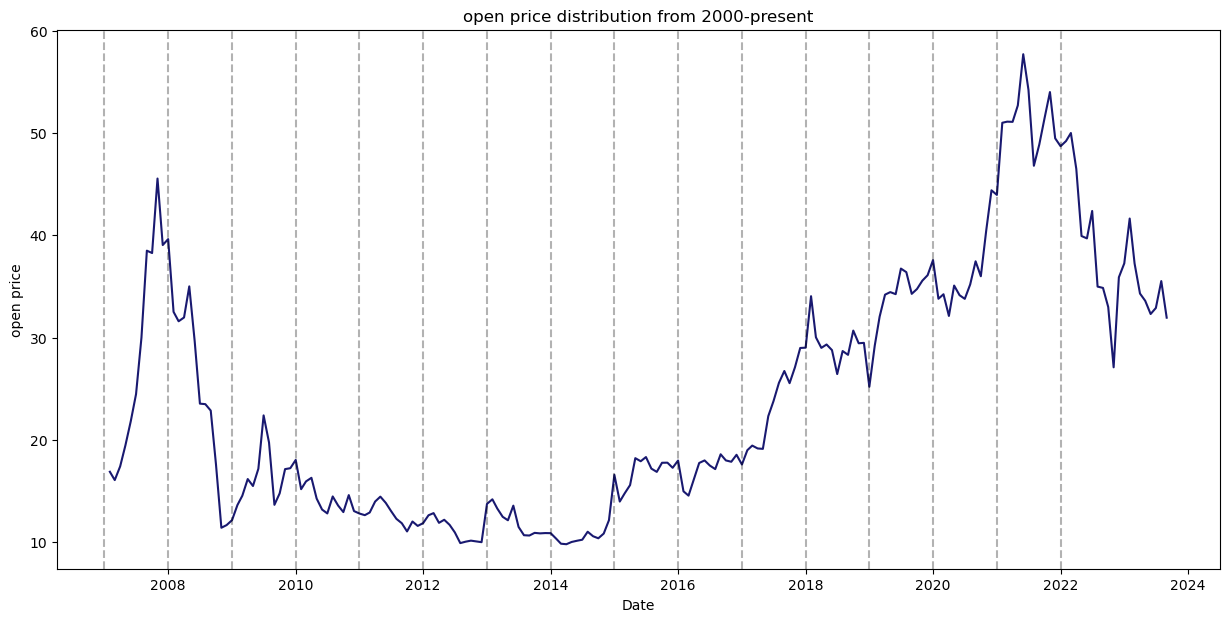

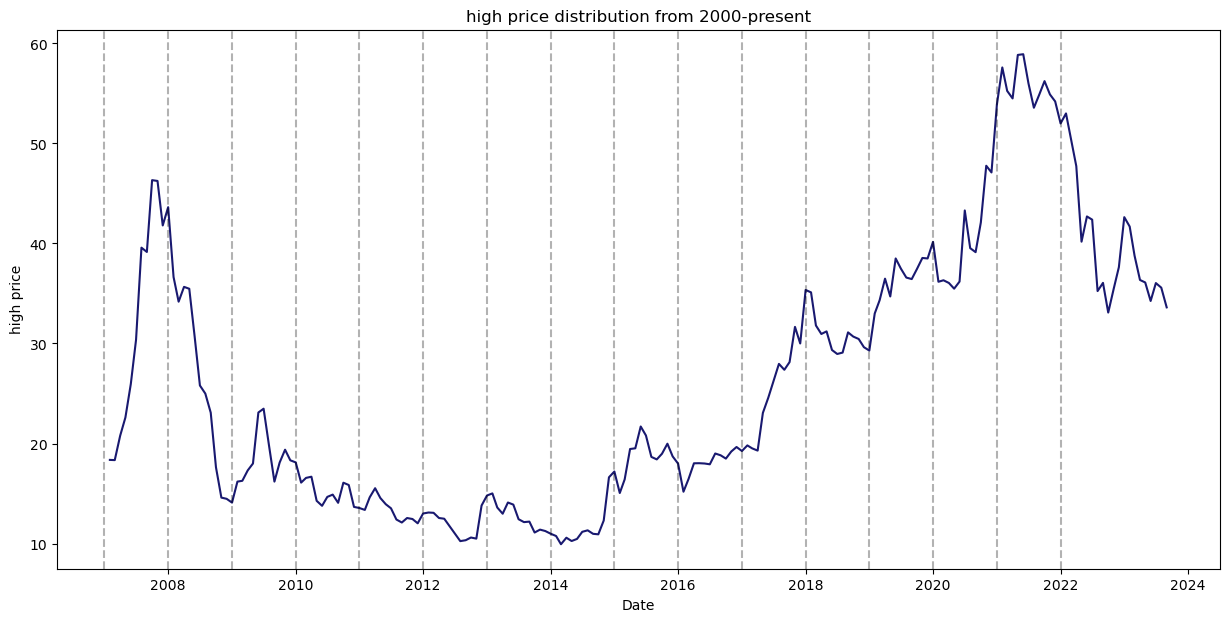

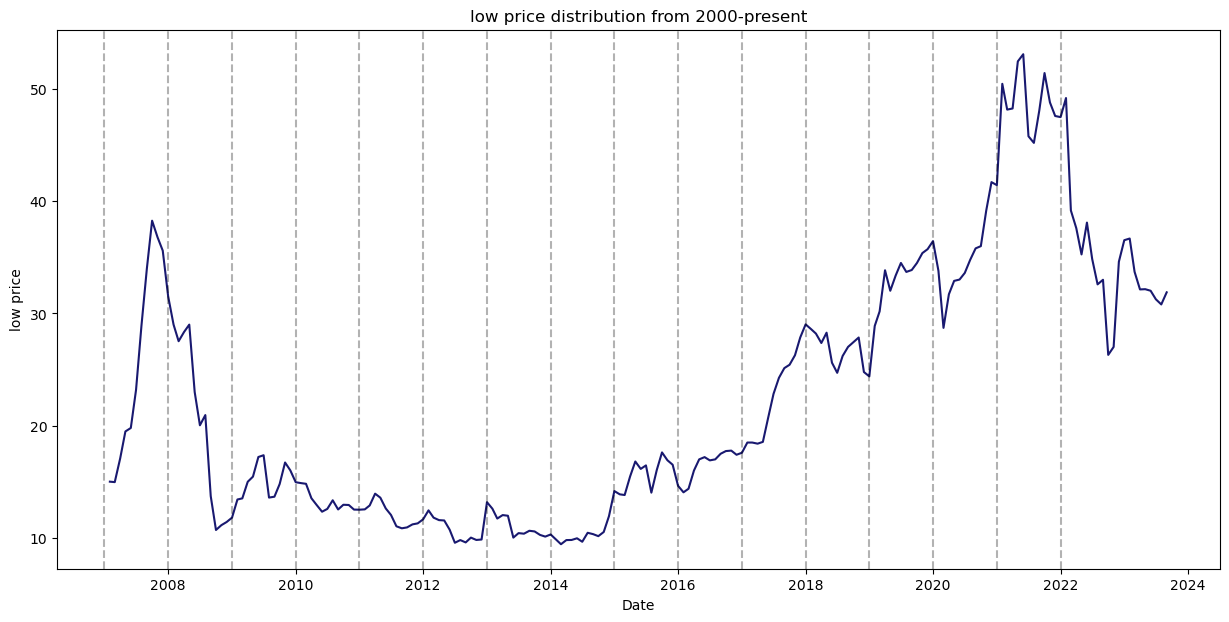

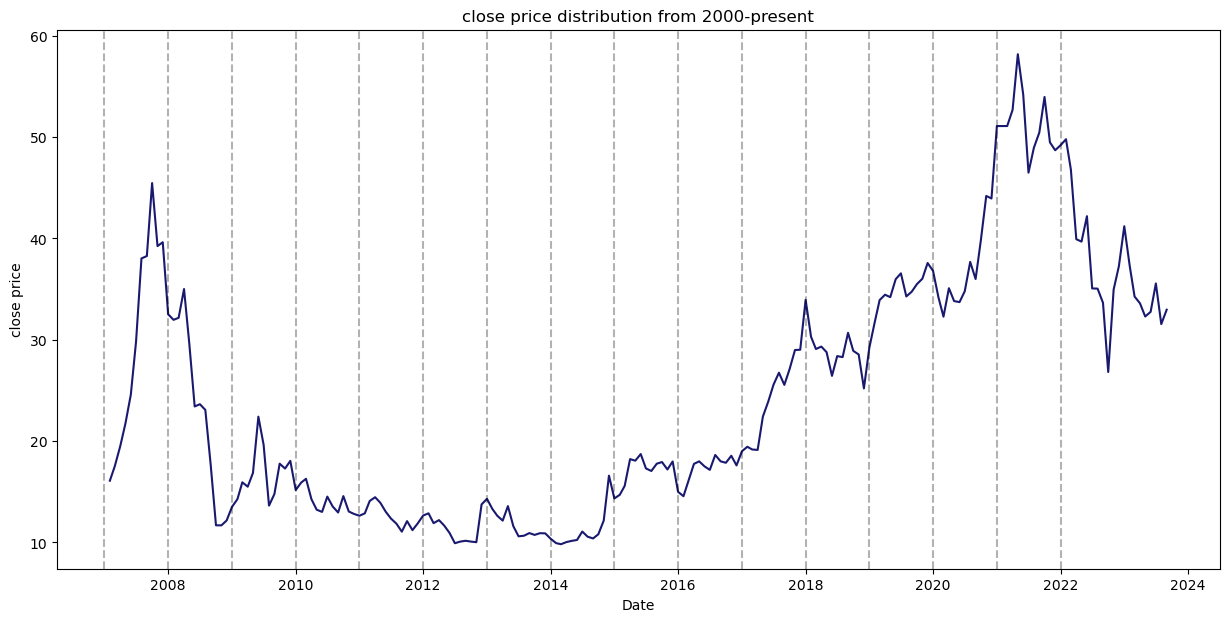

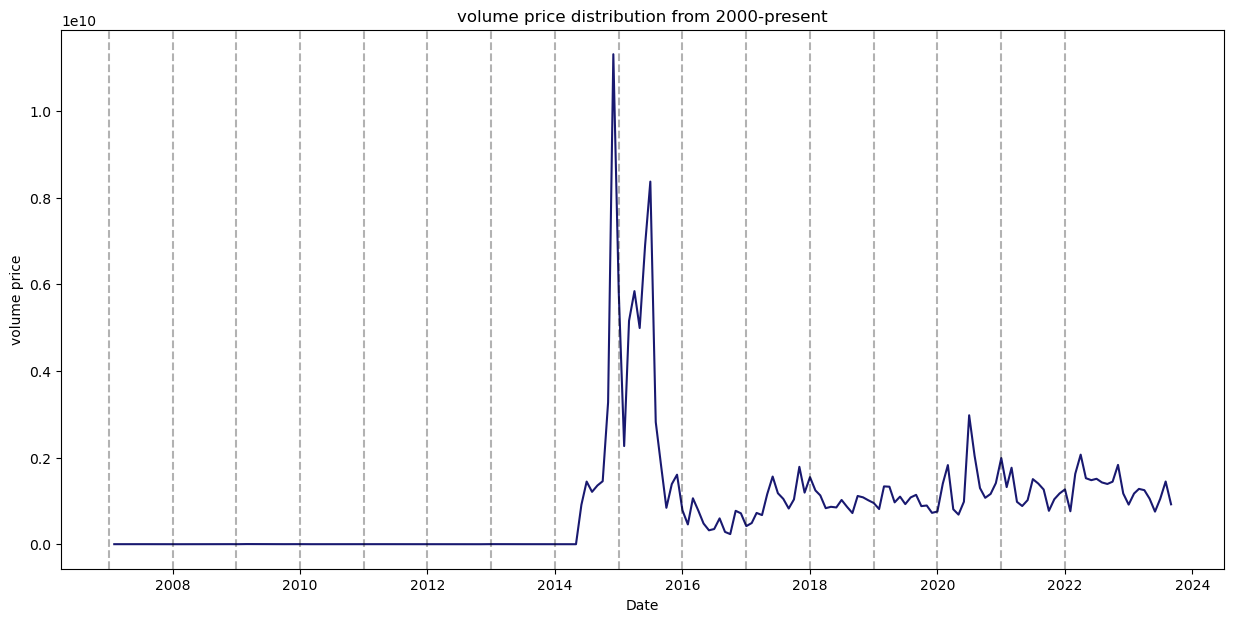

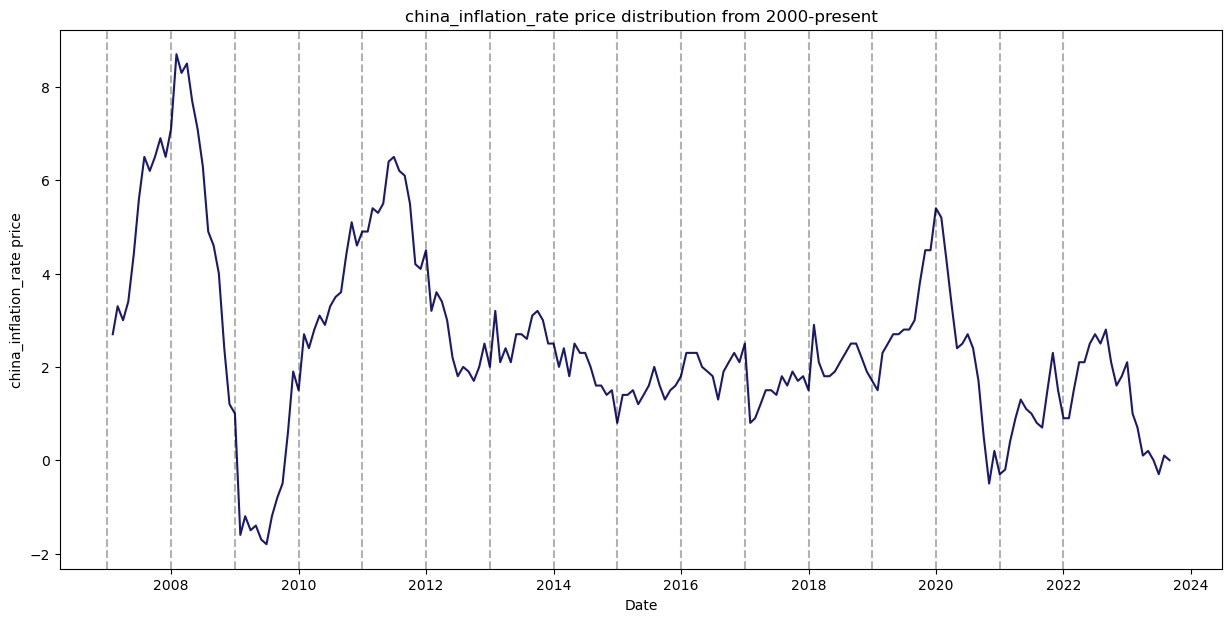

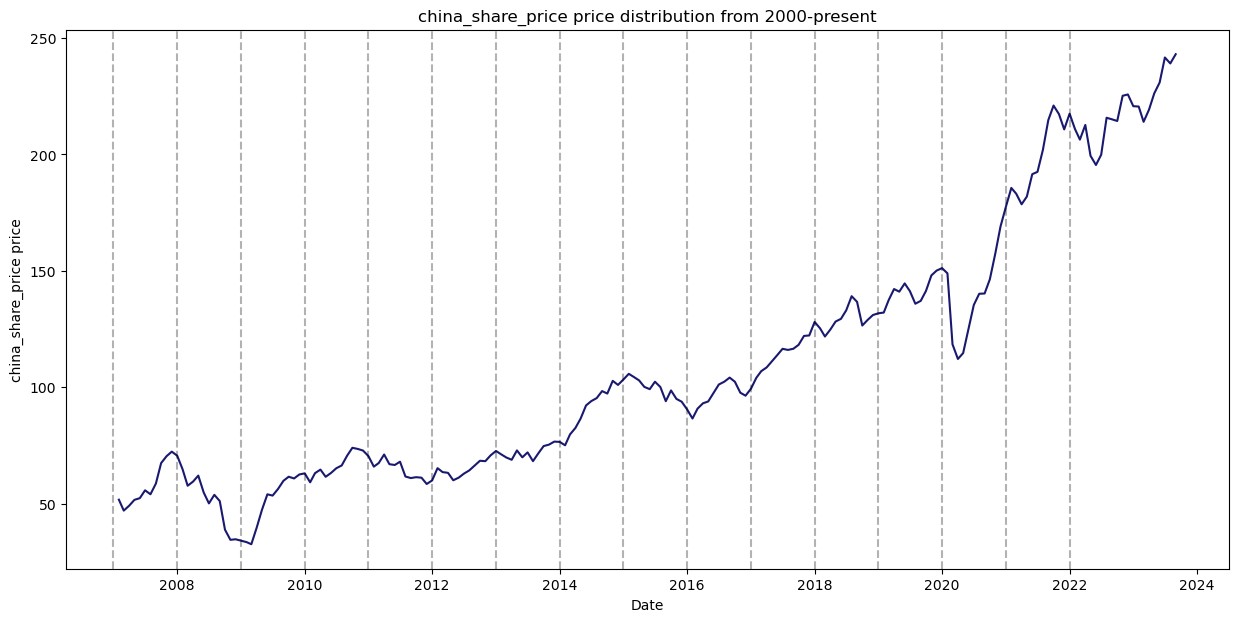

In [7]:
for col in data.columns:
    plot_price(data[col])

In [8]:
close_data = data['close'].diff().dropna()
open_data = data['open'].diff().dropna()
high_data = data['high'].diff().dropna()
low_data = data['low'].diff().dropna()
volume_data = data['volume'].diff().dropna()
china_inflation_rate_data = data['china_inflation_rate'].diff().dropna()
china_share_price_data = data['china_share_price'].diff().dropna()

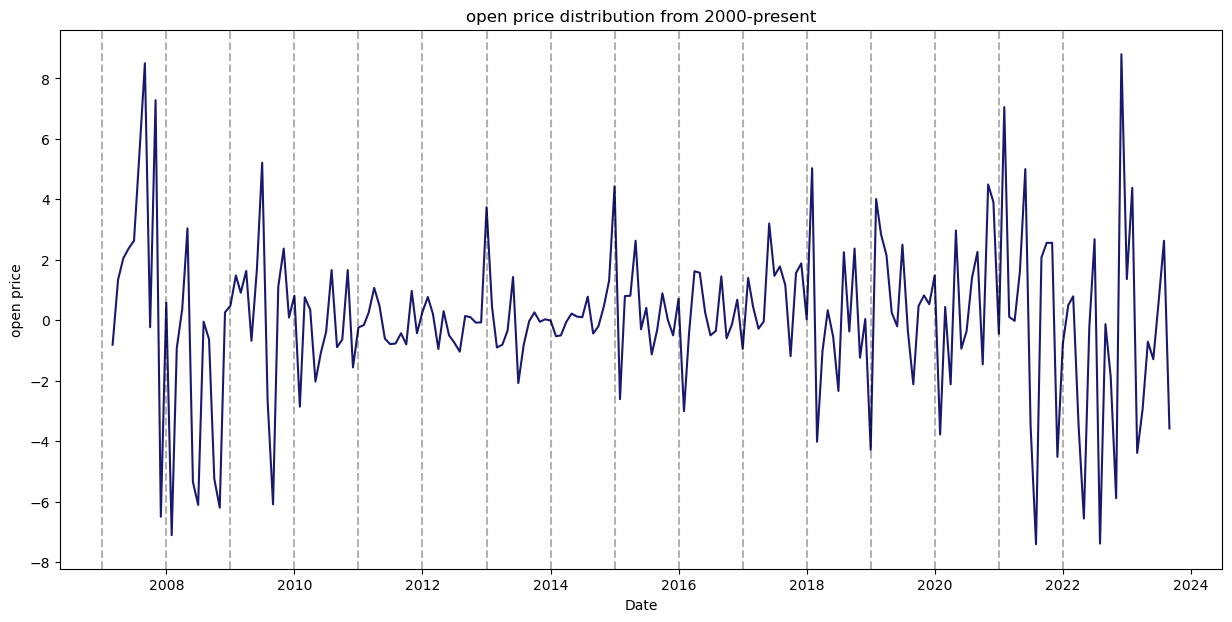

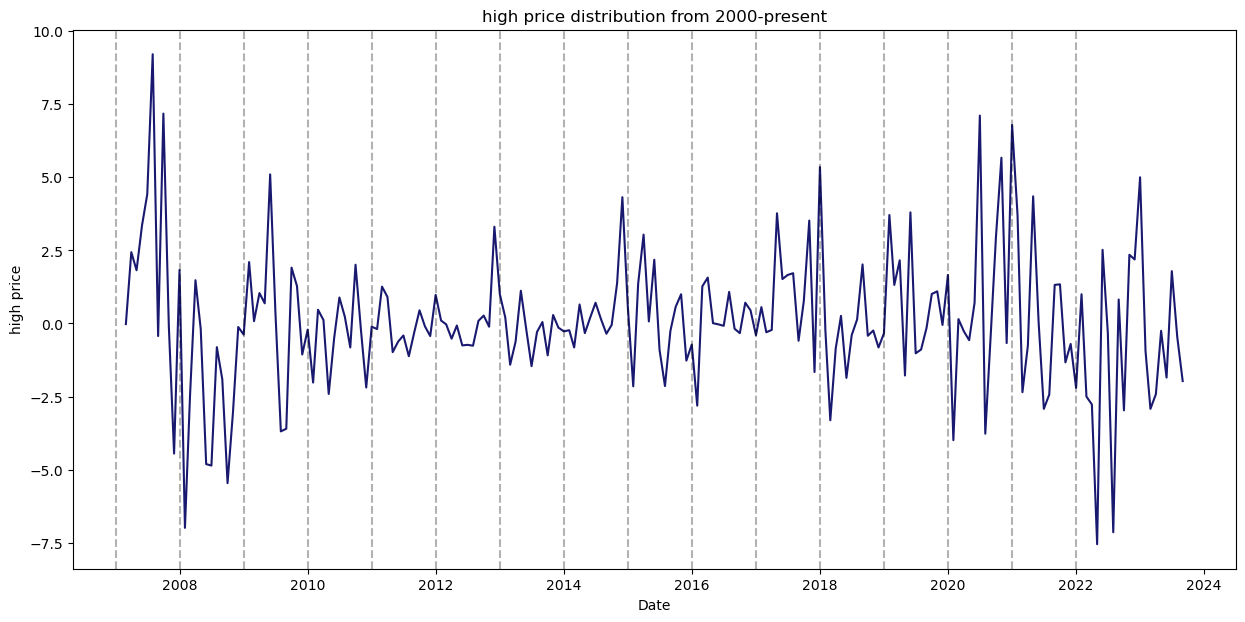

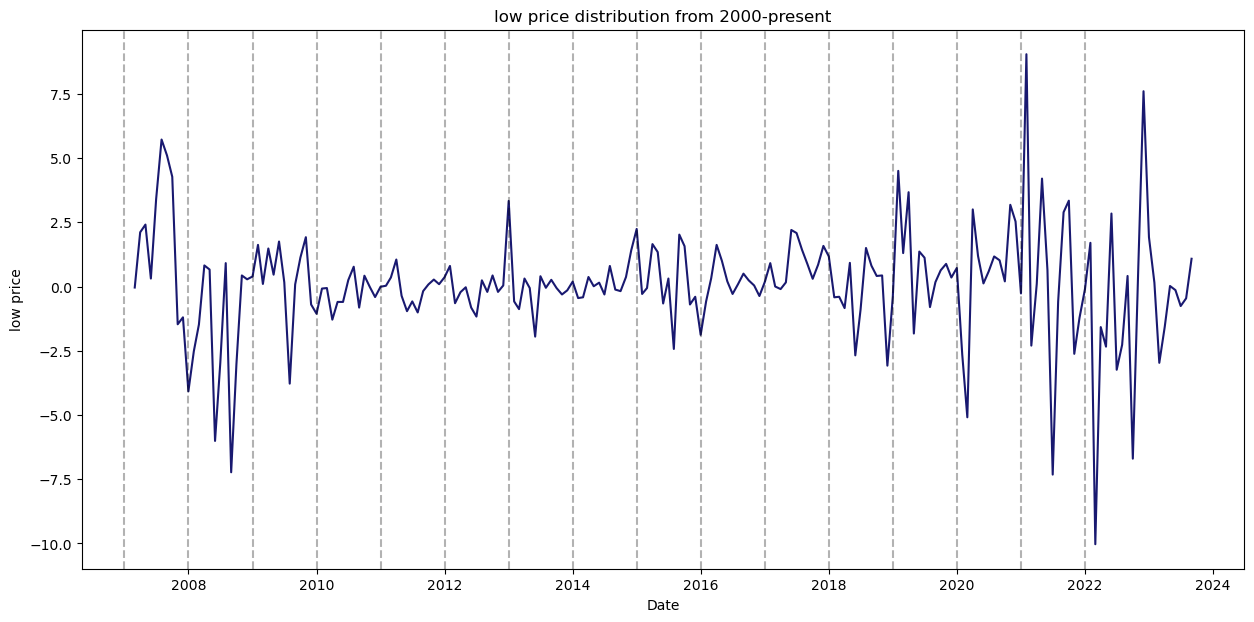

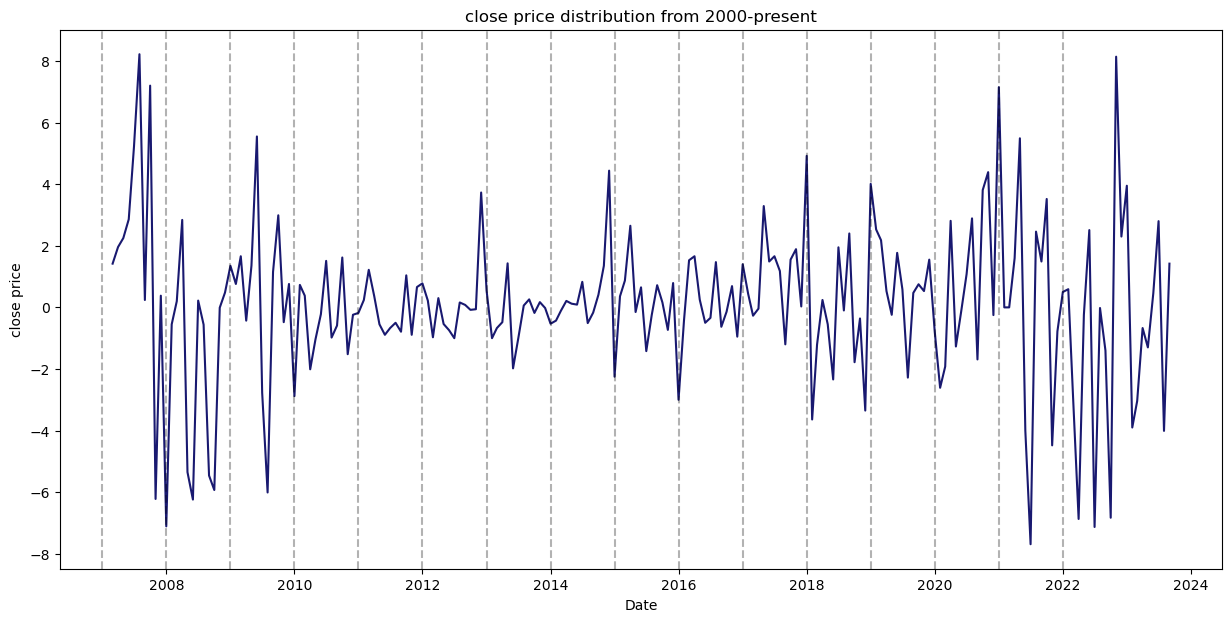

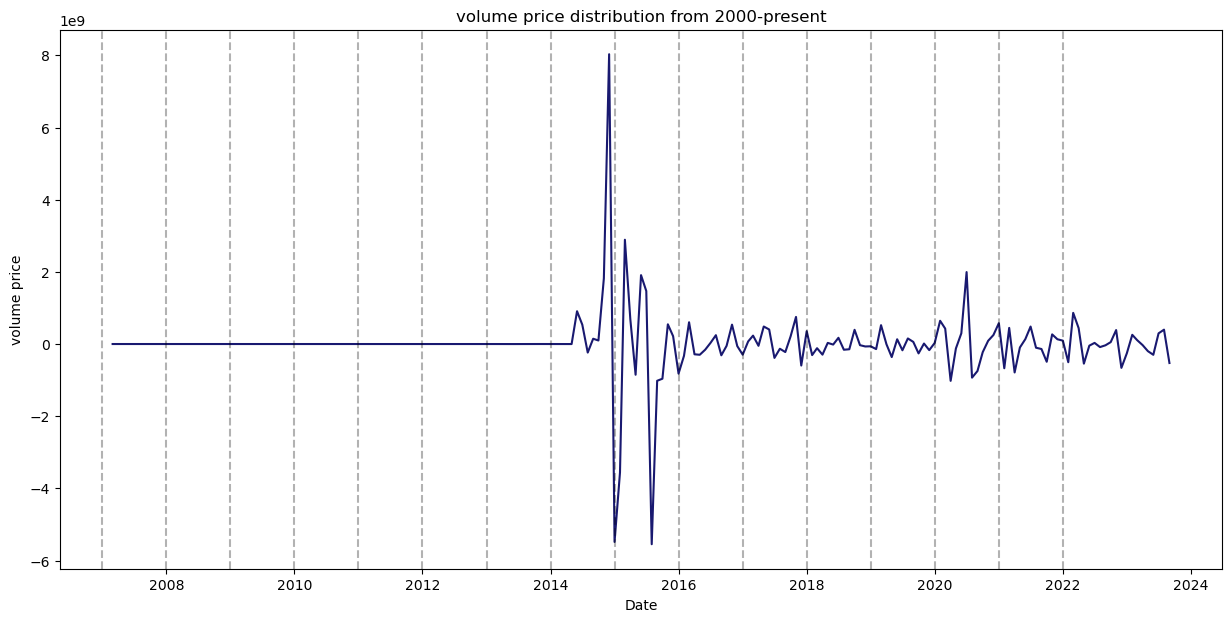

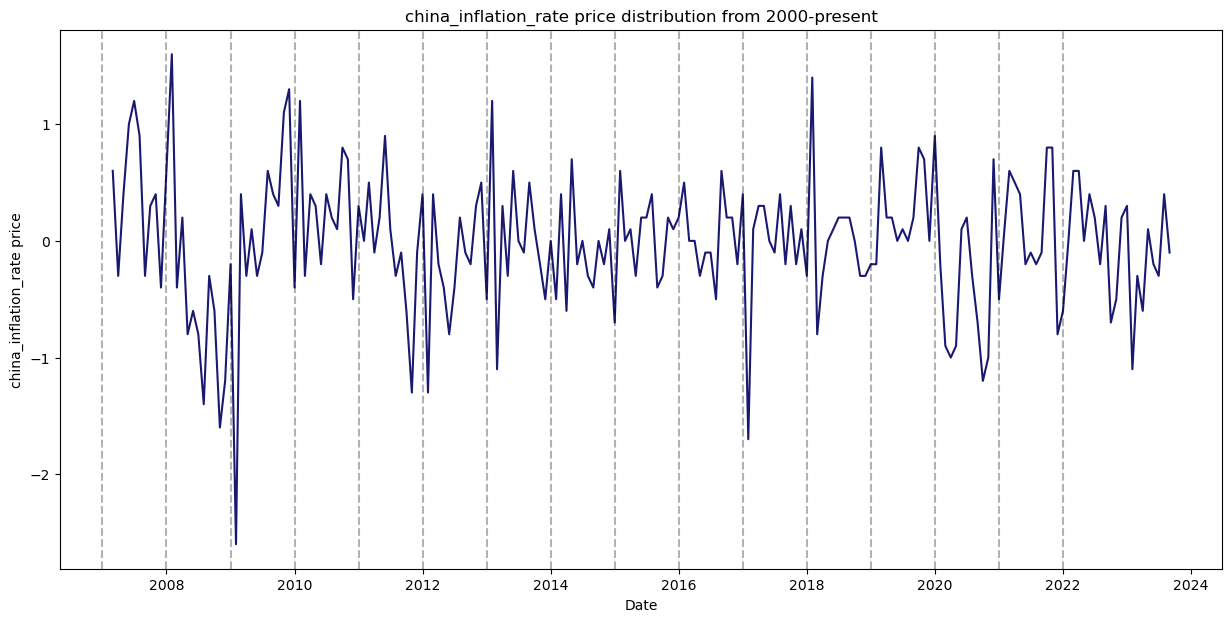

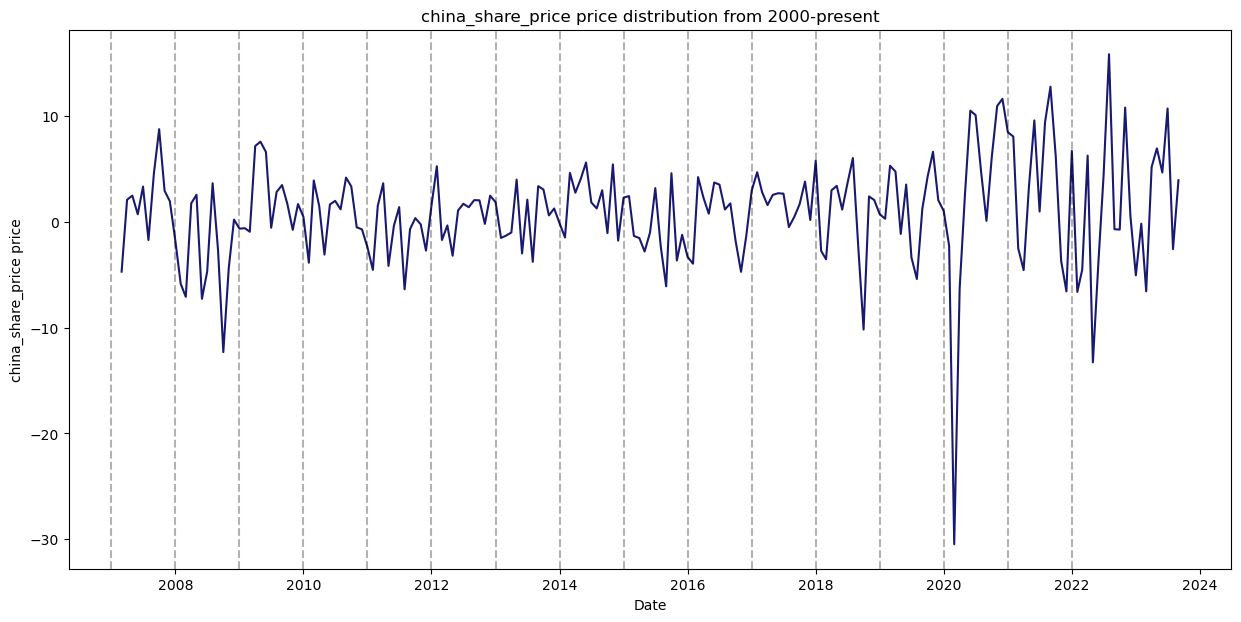

In [9]:
for col in data.columns.values:
    col_name = globals()[f'{col}_data']
    plot_price(col_name)


In [10]:
close_std = close_data.groupby([close_data.index.year]).std()
open_std = open_data.groupby([open_data.index.year]).std()
high_std = high_data.groupby([high_data.index.year]).std()
low_std = low_data.groupby([low_data.index.year]).std()
volume_std = volume_data.groupby([volume_data.index.year]).std()
china_inflation_rate_std = china_inflation_rate_data.groupby([china_inflation_rate_data.index.year]).std()
china_share_price_std = china_share_price_data.groupby([china_share_price_data.index.year]).std()

close_volatility = close_data.index.map(lambda dt: close_std.loc[dt.year])
open_volatility = open_data.index.map(lambda dt: open_std.loc[dt.year])
high_volatility = high_data.index.map(lambda dt: high_std.loc[dt.year])
low_volatility = low_data.index.map(lambda dt: low_std.loc[dt.year])
volume_volatility = volume_data.index.map(lambda dt: volume_std.loc[dt.year])
china_inflation_rate_volatility = china_inflation_rate_data.index.map(lambda dt: china_inflation_rate_std.loc[dt.year])
china_share_price_volatility = china_share_price_data.index.map(lambda dt: china_share_price_std.loc[dt.year])

close_data = close_data / close_volatility
open_data = open_data / open_volatility
high_data = high_data / high_volatility
low_data = low_data / low_volatility
volume_data = volume_data / volume_volatility
china_inflation_rate_volatility = china_inflation_rate_data / china_inflation_rate_volatility
china_share_price_volatility = china_share_price_data / china_share_price_volatility

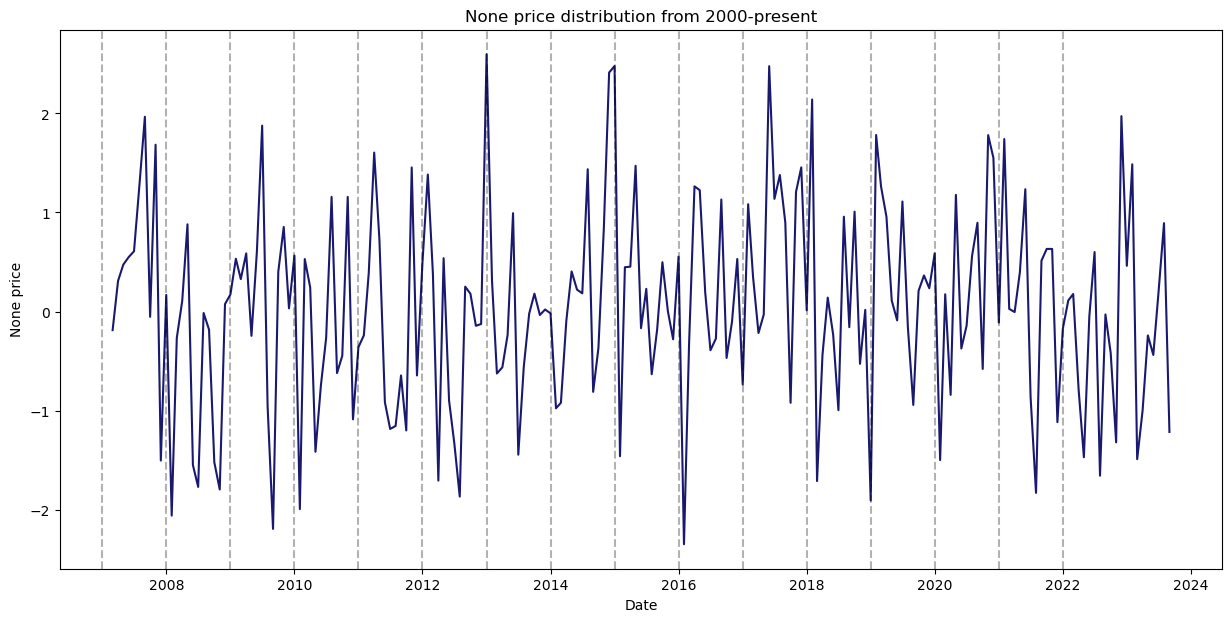

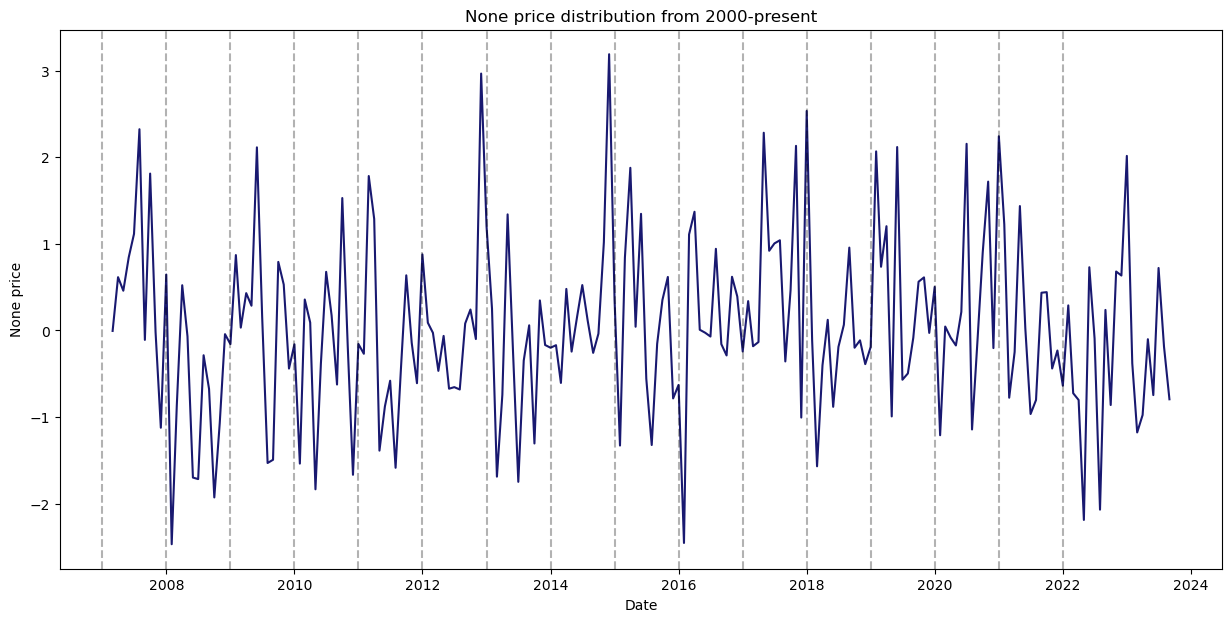

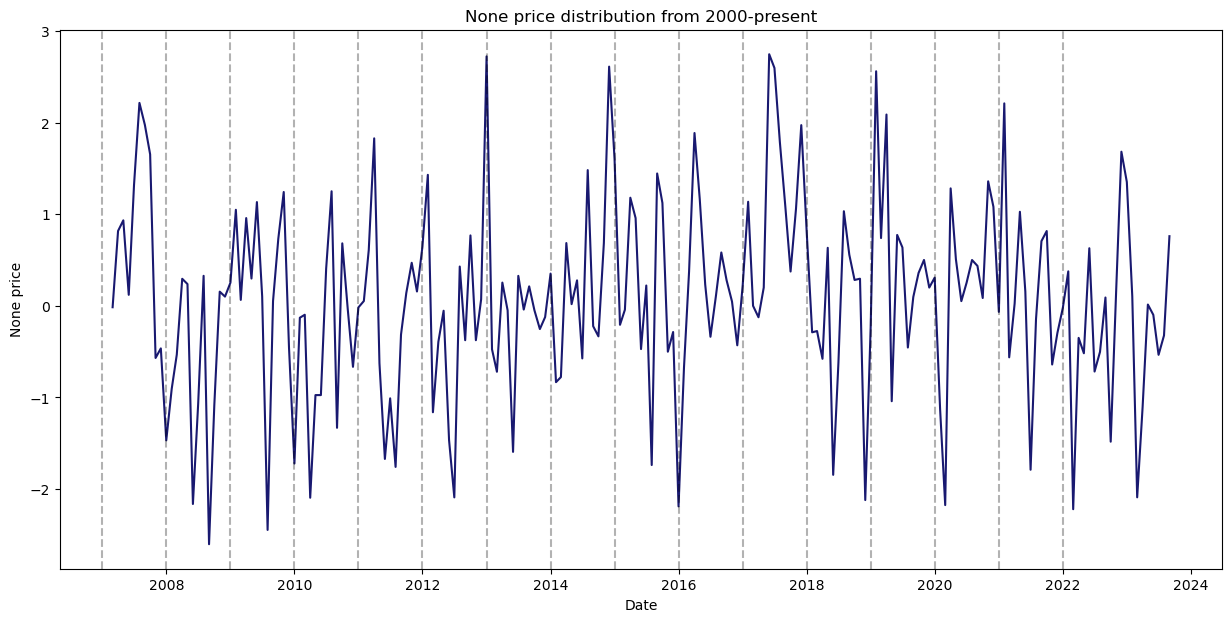

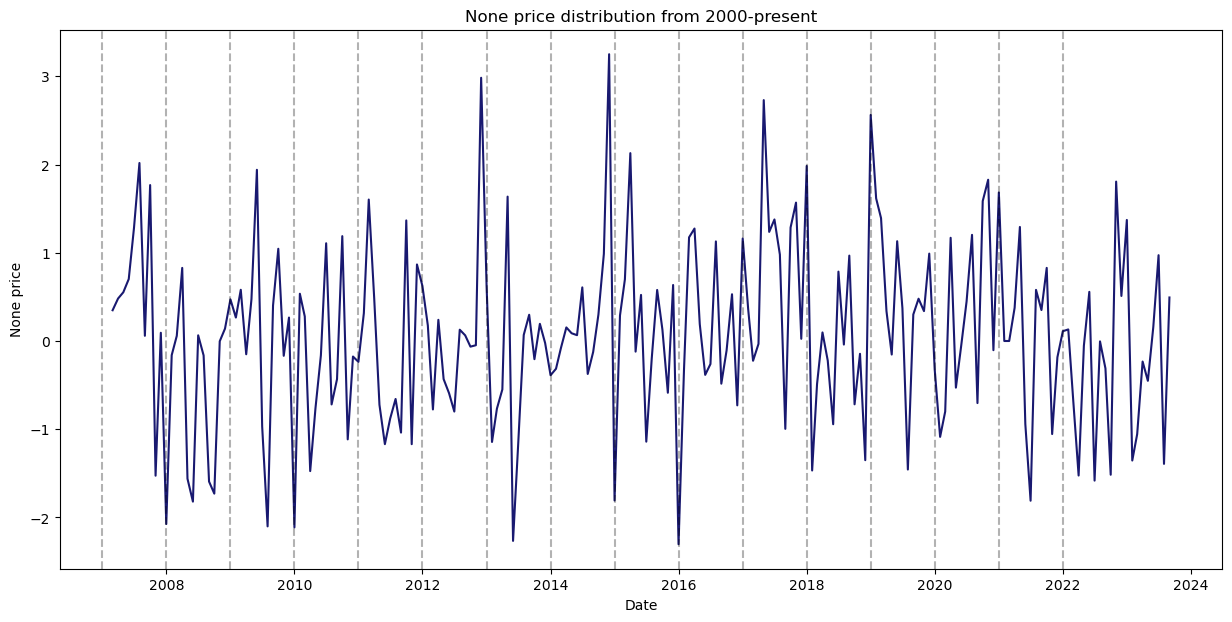

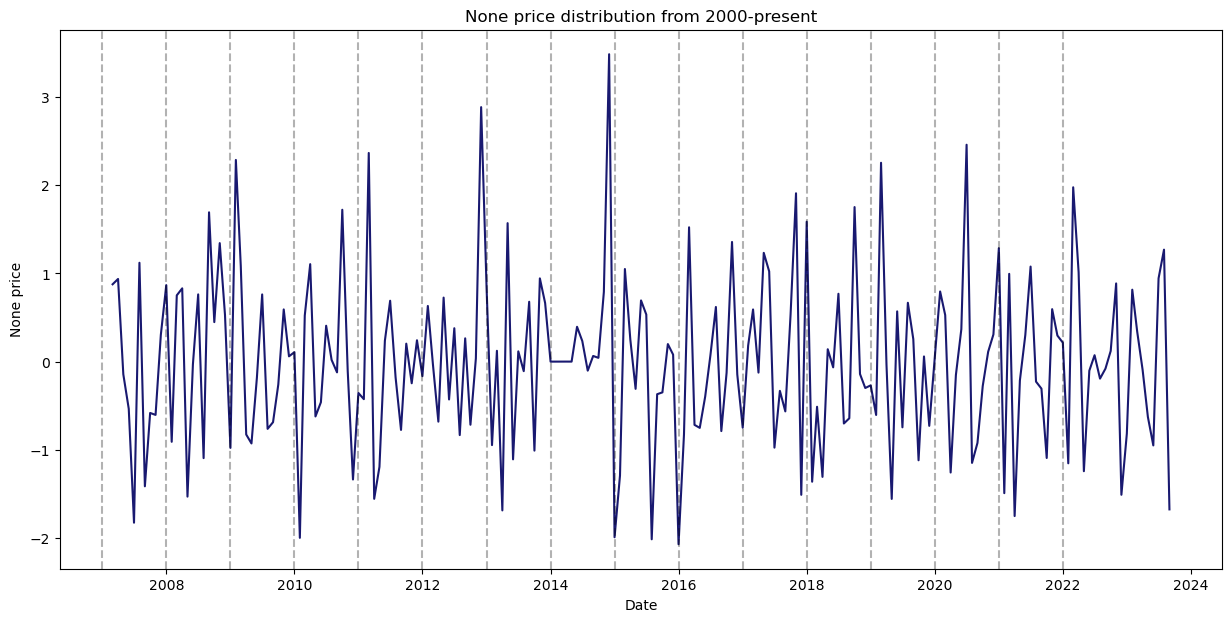

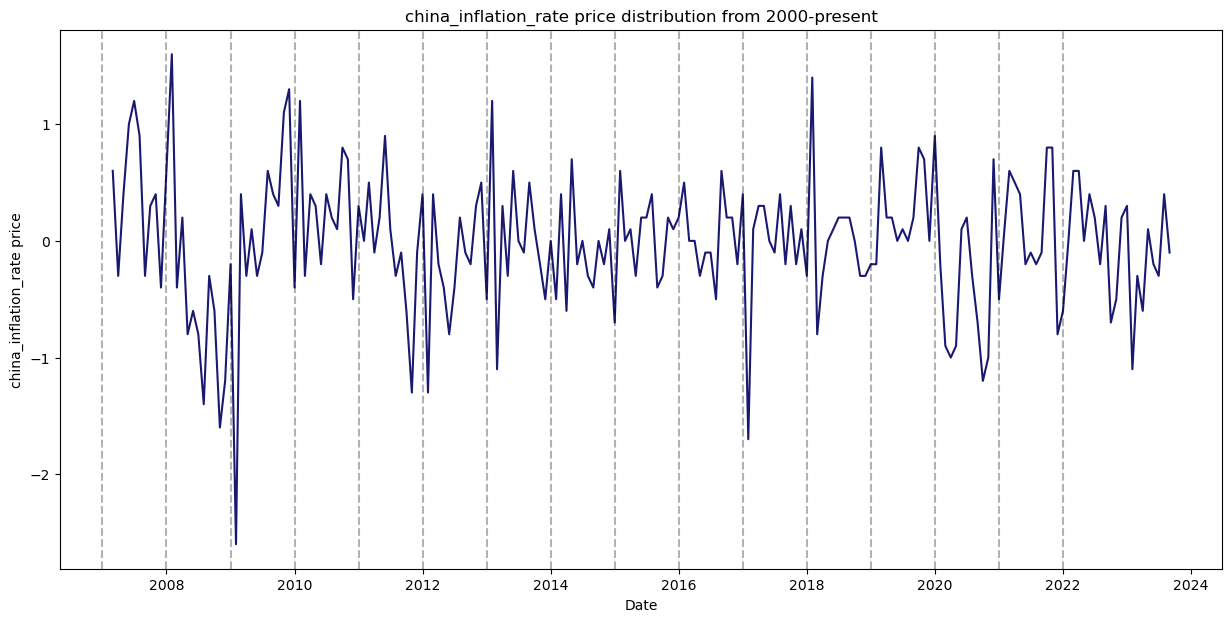

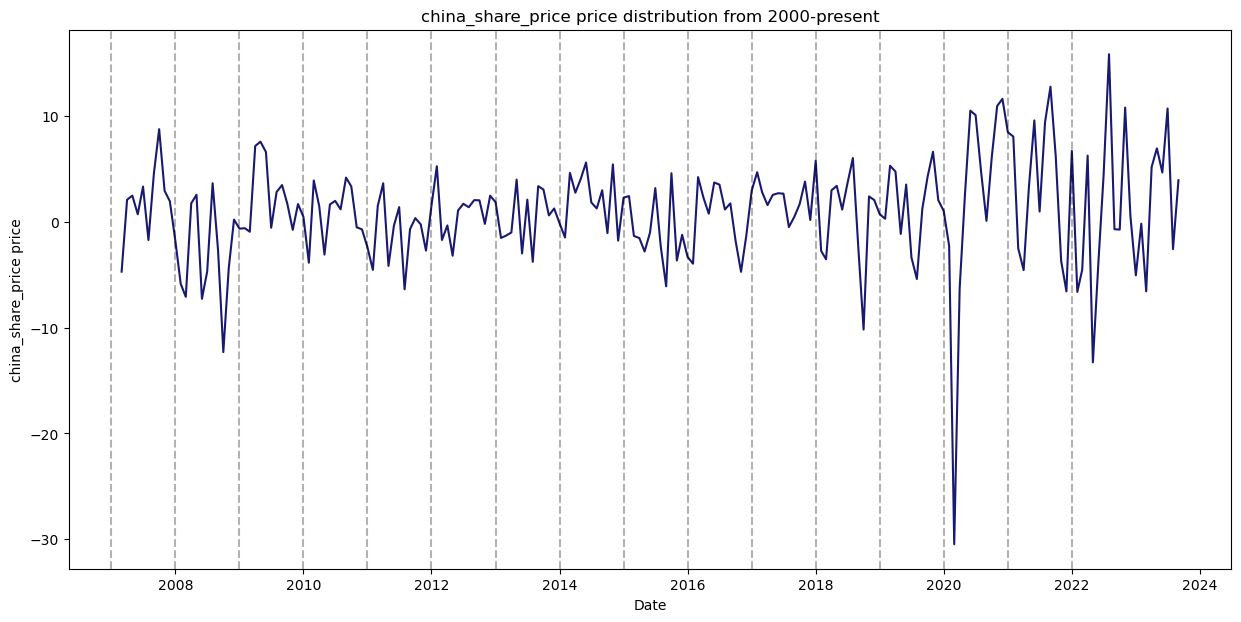

In [11]:
for col in data.columns.values:
    col_name = globals()[f'{col}_data']
    plot_price(col_name)

In [12]:
final_data = pd.DataFrame({'open': open_data.values,
                           'high': high_data.values,
                           'low': low_data.values,
                           'close': close_data.values,
                           'volume': volume_data.values,
                           'china_inflation_rate': china_inflation_rate_data,
                           'china_share_price': china_share_price_data},
                            index=data.index[1:])

In [13]:
start_date = final_data.index[0].date()
end_date = date(2022, 12, 1)

month_diff = math.ceil((end_date - start_date).days / 30)
train_start_idx = final_data.index[0]
train_end_idx = final_data.index[month_diff]

test_start_idx = final_data.index[month_diff+1]


x = ['open', 'high', 'low', 'volume', 'china_inflation_rate', 'china_share_price']
y = ['close']

train_data = final_data[:train_end_idx]
test_data = final_data[test_start_idx:]

In [14]:
arima_model = ARIMA(endog=train_data.loc[:, y],
                    exog=train_data.loc[:, x],
                    order=(1, 0, 1))

model_fit = arima_model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  193
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -150.706
Date:                Thu, 16 Nov 2023   AIC                            321.412
Time:                        18:27:24   BIC                            354.039
Sample:                    03-01-2007   HQIC                           334.625
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0215      0.017      1.253      0.210      -0.012       0.055
open                    -0.5234      0.056     -9.275      0.000      -0.634      -0.413
high        

In [15]:
predicted_close = model_fit.predict(start=test_data.index[0],
                                    end=test_data.index[-1],
                                    exog=test_data.loc[:, x])

residuals = test_data['close'].values - predicted_close

# get the RMSE value to see how well the model performed

print(f"Root Mean Square Error: {np.sqrt(np.mean(residuals**2))}")

Root Mean Square Error: 0.5434101853293698


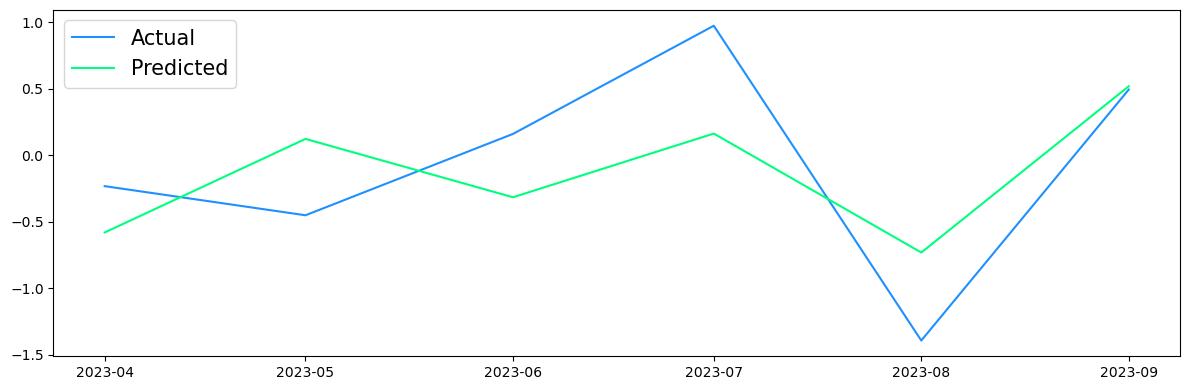

In [16]:

plt.figure(figsize=(12, 4))
plt.plot(test_data['close'], color='dodgerblue')
plt.plot(predicted_close, color='springgreen')

plt.legend(('Actual', 'Predicted'), fontsize=15)
plt.tight_layout()
plt.show()
